In [1]:
import ROOT
import warnings

import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate, stats
from lmfit import Parameters, minimize

from scipy.optimize import curve_fit 
from tqdm import tqdm

from scipy.signal import fftconvolve
from scipy.special import gamma

warnings.filterwarnings('ignore')

# Width of the resonance in keV
width = 0.0067
width_err = 0.0005

# Boltzmann constant in keV/K
k = 8.617e-5

# Doppler effect
dopp = np.sqrt( 2 * 1.007 / 27 * 0.991 * k * ( 80 + 273 ) )

print( 'Doppler effect =', dopp )

Doppler effect = 0.04741874738287317


In [2]:
import stragg

import sys
stdout = sys.stdout

class Straggling:

    emGraph   = ROOT.TGraph( )
    gvGraph   = ROOT.TGraph( )
    vvGraph   = ROOT.TGraph( )
    demGraph  = ROOT.TGraph( )
    betaGraph = ROOT.TGraph( )
    xiGraph   = ROOT.TGraph( )
    kGraph    = ROOT.TGraph( )

    landau       = stragg.LandauFunction( )
    gauss        = stragg.GaussFunction( )
    vavilovAiry  = stragg.VavilovAiryFunction( )
    vavilovMoyal = stragg.VavilovMoyalFunction( )
    vavilovEdgew = stragg.VavilovEdgeworthFunction( )

    def __init__( self, element, energy ):
        self.energy = energy
        self.layer = stragg.Layer( element )
        self.layer_oxide = stragg.Layer( 8 )

    def get_stopping_power( self, energy ):
        return self.layer.EvaluateZiegler( energy )

    def prepare( self ):

        self.vvGraph.AddPoint( -100, 0 )
        self.vvGraph.AddPoint( 0, 0 )

        em   = self.energy
        gv   = 0
        vv   = 0
        dem  = 0
        xi   = 0
        k    = 0

        self.layer.setThicknessStep( 0.1 )
        self.layer_oxide.setThicknessStep( 0.1 )

        while ( (self.energy - em) < 50 ):

            de = self.energy - em
            if de < 0.0:
                deml_o = self.layer_oxide.GetDEML(em)
                gvl_o  = self.layer_oxide.GetGVL(em)
                vvl_o  = self.layer_oxide.GetVVL(em)
                kl_o   = self.layer_oxide.GetK(em)
                beta_o = self.layer_oxide.GetBeta(em)
                xilO  = self.layer_oxide.GetXi(em)
                deml_al = self.layer.GetDEML(em)
                gvl_al  = self.layer.GetGVL(em)
                vvl_al  = self.layer.GetVVL(em)
                kl_al   = self.layer.GetK(em)
                beta_al = self.layer.GetBeta(em)
                xil_al  = self.layer.GetXi(em)
                deml = 3 / 5 * deml_o + 2 / 5 * deml_al
                gvl  = 3 / 5 * gvl_o + 2 / 5 * gvl_al
                vvl  = 3 / 5 * vvl_o + 2 / 5 * vvl_al
                kl   = 3 / 5 * kl_o + 2 / 5 * kl_al
                beta = 3 / 5 * beta_o + 2 / 5 * beta_al
                xil  = 3 / 5 * xilO + 2 / 5 * xil_al

            else:
                deml = self.layer.GetDEML(em)
                gvl  = self.layer.GetGVL(em)
                vvl  = self.layer.GetVVL(em)
                kl   = self.layer.GetK(em)
                beta = self.layer.GetBeta(em)
                xil  = self.layer.GetXi(em)

            em  -= deml
            dem += deml
            k   += kl
            gv = np.sqrt(gv*gv + gvl*gvl)
            vv = np.sqrt(vv*vv + vvl*vvl)
            xi = xi + xil

            self.emGraph.AddPoint( dem, em )
            self.demGraph.AddPoint( dem, dem )
            self.kGraph.AddPoint( dem, k )
            self.gvGraph.AddPoint( dem, gv )
            self.vvGraph.AddPoint( dem, vv )
            self.xiGraph.AddPoint( dem, xi )
            self.betaGraph.AddPoint( dem, beta )

strag = Straggling( 13, 991 )
strag.prepare( )

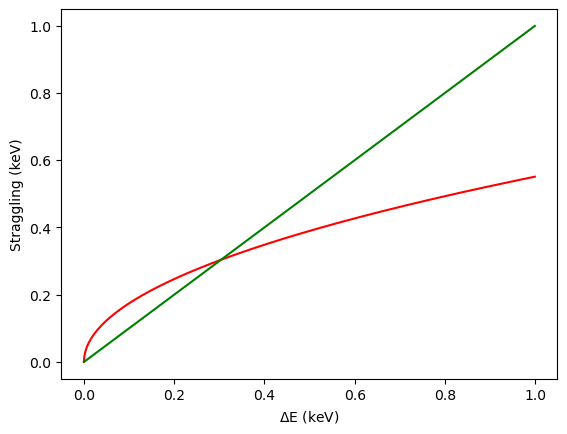

In [3]:
npoints = 1000

x = np.zeros( ( npoints ) )
y = np.zeros( ( npoints ) )

for i in range( npoints ):
    x[i] = i * 0.001
    y[i] = strag.vvGraph.Eval( i * 0.001 )

plt.ylabel( 'Straggling (keV)' )
plt.xlabel( r'$\Delta$E (keV)' )

def func( x, a ):
    return a * np.sqrt( x )

popt, pcov = curve_fit( func, x, y )

mod = func( x, *popt )

def straggling( x ):
    return popt[0] * np.sqrt( x ) / 1.2

plt.plot( x, straggling( x ), 'r' )
plt.plot( x, x, 'g' )

plt.show( )

In [4]:
# Load the data skipping the header
data = np.loadtxt( 'data/Data_991_2023.txt', skiprows=1 )
x, obs, err = data[:,0], data[:,1], data[:,2]

In [5]:
# Gamma function for the straggling
def gamma_function(x, a, b):
    return (b**a) * (x**(a-1)) * np.exp(-b*x) / gamma(a)

# Dirac delta function
def delta_dirac(x, x0):
    idx = (np.abs(x - x0)).argmin()
    return np.zeros_like(x) + (x == x[idx]) * 1e6

# Gaussian kernel
def gaussian_kernel(size, sigma, dx):
    # size = number of points in the kernel
    xg = np.linspace(-size // 2, size // 2, size) * dx
    kernel = np.exp(-xg**2 / (2 * sigma**2))
    return kernel / kernel.sum(), xg

# Smooth step function
def smooth_step(x, k=60, x0=0.1):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Function to convolve the straggling with a Gaussian
def convolve(de, sigma):

    if de > 0:
        # Original x-array and function
        x = np.linspace(0.01, 5, 5000)
        s = straggling( de )
        dx = x[1] - x[0]  # spacing
        a = de**2 / s**2
        b = de / s**2
        f = gamma_function( x, a, b )
    else:
        x = np.linspace(-1, 1, 1000)
        dx = x[1] - x[0]  # spacing
        f = delta_dirac( x, de )

    # Create the kernel
    kernel_size = 1000
    g, xg = gaussian_kernel(kernel_size, sigma, dx)

    # Full convolution
    convolved = fftconvolve(f, g, mode='full')

    # New x-axis after convolution
    x_full = np.linspace(
        x[0] + xg[0],
        x[-1] + xg[-1],
        len(convolved)
    )

    return x_full, convolved

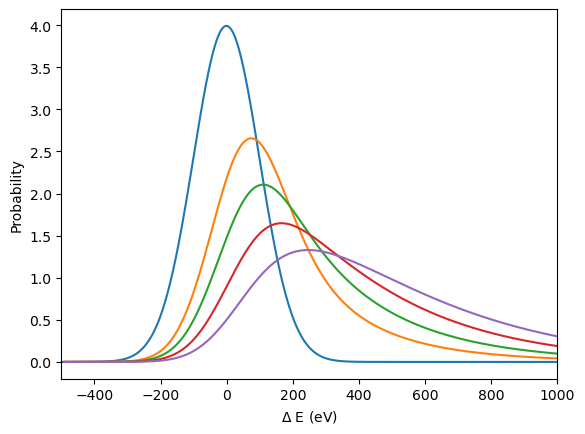

In [6]:
de = np.linspace(0, 0.5, 5)

for d in de:
    x_full, convolved = convolve(d, 0.1)
    norm = np.sum(convolved) * (x_full[1] - x_full[0])
    plt.plot(x_full * 1e3, convolved / norm, label=r'$\Delta$ E = {:.2f} eV'.format(d * 1e3))

plt.xlim(-500, 1000)
plt.ylabel('Probability')
plt.xlabel(r'$\Delta$ E (eV)')

plt.show( )

In [7]:
def gaussian( x, x0, s ):
    return ( 1. / ( np.sqrt(2.*np.pi) * s ) ) * np.exp( -(x - x0)**2 / ( s*s*2 ) )

def stoichiometry( x, theta ):
    norms = smooth_step( x, k=theta[5], x0=theta[4] )
    initial = theta[3] / 3
    return 3 * norms * initial + initial

def cross_section( x0, theta, de_res, de ):
    norm = stoichiometry( de, theta )
    return theta[1] / ( ( de_res - x0 )**2 + ( theta[1] / 2 )**2 ) * norm

def integrand( x, theta, x0 ):
    de, de_res = x0 - x, x0 - theta[2]
    
    # Get beam width
    s = np.sqrt( pow( theta[0], 2 ) + pow( dopp, 2 ) )

    # Convolve the gaussian with the straggling
    array, gauss = convolve( de, s )

    # Normalize the gaussian
    step = array[1] - array[0]
    norm  = np.sum( gauss ) * step
    
    # Convolve
    conv = np.sum( gauss * cross_section( array, theta, de_res, de ) ) * step / norm

    return conv

def straggled_profile( x, theta ):
    y = np.zeros( shape=len( x ) )
    for idx in range( len( x ) ):
        xmin, xmax = x[idx] - 5, x[idx]
        nsteps = 100
        dx = np.abs( xmax - xmin ) / nsteps
        y[idx] = integrate.simpson( [ integrand( x_i, theta, x[idx] ) for x_i in np.linspace( xmin, xmax, nsteps) ], dx=dx )
    return y

def model( x, theta ):
    sign = straggled_profile( x, theta[:-1] )
    back = theta[-1]
    return sign + back

def chi2( theta ):
    theta = list( theta.valuesdict().values() )
    mod   = model( x, theta )
    res   = ( obs - mod ) / err
    print( "Chi2: {:10.4f}".format(np.sum(res**2)), end="\r" )
    return res

In [8]:
params = Parameters()
params.add('beam',     value=0.07,    vary=True)
params.add('width',    value=0.067,   vary=False)
params.add('edge',     value=982.28,  vary=True)
params.add('height',   value=0.20,    vary=True, min=0)
params.add('oxide',    value=0.15,    vary=True, min=0, max=0.5)
params.add('slope',    value=7,       vary=True, min=0, max=200)
params.add('scale',    value=1,       vary=False)
params.add('back1',    value=0,       vary=True)

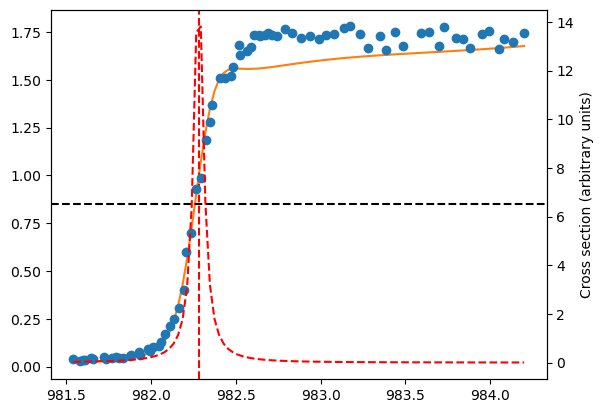

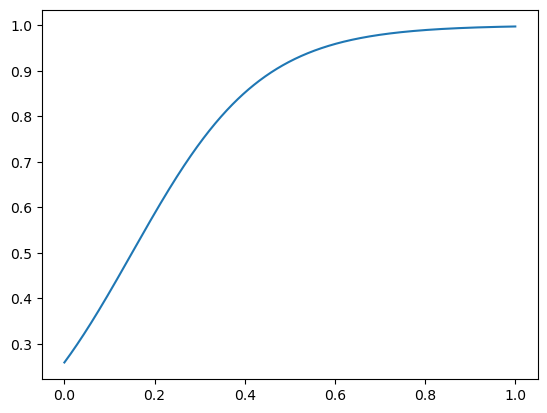

In [9]:
theta = list( params.valuesdict().values() )

grid = np.linspace( x.min( ), x.max( ), 100 )

mod = model( grid, theta )
cross = cross_section( grid, theta, theta[2], 1 )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o' )
plt.plot( grid, mod, '-' )

plt.axvline( theta[2], color='r', linestyle='--', label='Resonance' )

ymin, ymax = min( mod ), max( mod )
ymean = ( ymin + ymax ) / 2
plt.axhline( ymean, color='k', linestyle='--', label='Mean' )

# Plot cross section on secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot( grid, cross, 'r--', label='Cross section' )
ax2.set_ylabel('Cross section (arbitrary units)')

plt.show( )

grid_oxide = np.linspace(0, 1, 1000)
oxide_step = smooth_step( grid_oxide, k=params["slope"], x0=params["oxide"] )

plt.plot( grid_oxide, oxide_step, label='Smooth step function' )

plt.show( )

In [10]:
out = minimize(chi2, params, method="least_squares")

print(f'Nvars {out.nvarys}              Ndata {out.ndata}')
print(f'Chi2 {out.chisqr:11.5f}     Chi2 / Ndof {out.redchi:11.5f}')

theta, error = [], []
print("----------------------------------------")
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    theta.append( param.value )
    error.append( param.stderr )
    if( param.stderr == None ): param.stderr = 0
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

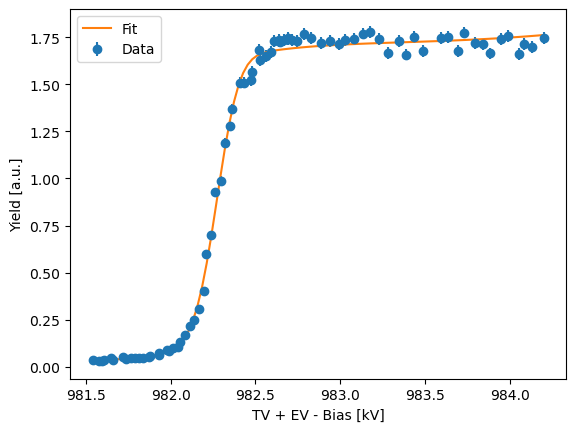

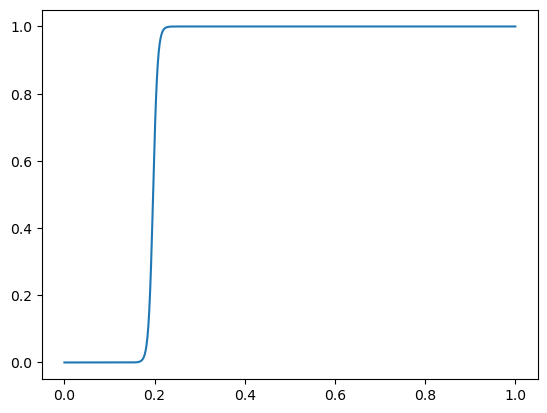

In [ ]:
# Increase font size
plt.rcParams.update({'font.size': 20})

mod = model( grid, theta )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o', label="Data" )
plt.plot( grid, mod, '-', label="Fit" )

plt.legend( )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

#plt.text( 625, 6, r'$\chi ^2 _r$: {:10.4f}'.format( out.redchi ) )

plt.savefig( "results/Fit_991_2024.pdf" )
plt.show( )

grid_oxide = np.linspace(0, 1, 1000)
oxide_step = smooth_step( grid_oxide, k=theta[5], x0=theta[4] )

plt.plot( grid_oxide * 1e3, oxide_step, label='Smooth step function' )
plt.ylabel( r'AlO$_{3}$ Percentage (%)' )
plt.xlabel( r'$\Delta$ E (eV)' )

plt.show( )

In [ ]:
# Print curve to txt file
with open( "results/Fit_991_2023.txt", "w" ) as f:
    for i in range( len( grid ) ):
        f.write( "{:10.4f} {:10.10f}\n".format( grid[i], mod[i] ) )

In [ ]:
# Load the data skipping the header
data = np.loadtxt( 'data/Data_991_2024.txt', skiprows=1 )
x, obs, err = data[:,0], data[:,1], data[:,2]

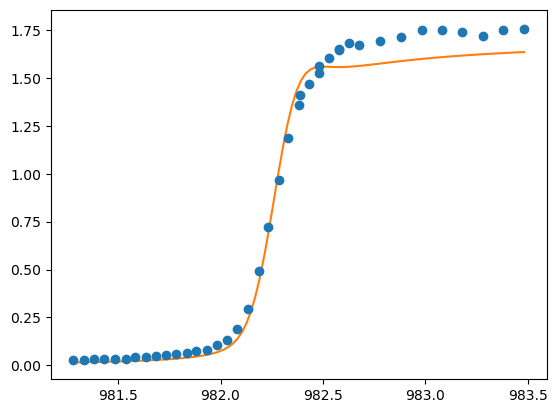

In [ ]:
theta = list( params.valuesdict().values() )

grid = np.linspace( x.min( ), x.max( ), 100 )

mod = model( grid, theta )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o' )
plt.plot( grid, mod, '-' )

plt.show( )

In [ ]:
out = minimize(chi2, params, method="least_squares")

print(f'Nvars {out.nvarys}              Ndata {out.ndata}')
print(f'Chi2 {out.chisqr:11.5f}     Chi2 / Ndof {out.redchi:11.5f}')

theta, error = [], []
print("----------------------------------------")
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    theta.append( param.value )
    error.append( param.stderr )
    if( param.stderr == None ): param.stderr = 0
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

Nvars 6              Ndata 40
Chi2   117.50527     Chi2 / Ndof     3.45604
----------------------------------------
Parameter    Value       Stderr
beam        0.09113     0.00682
width       0.06700     0.00000
edge      982.26304     0.01404
height      0.21240     0.00186
oxide       0.23882     5.15081
slope     199.99998 81429.01393
scale       1.00000     0.00000
back1       0.01569     0.00105


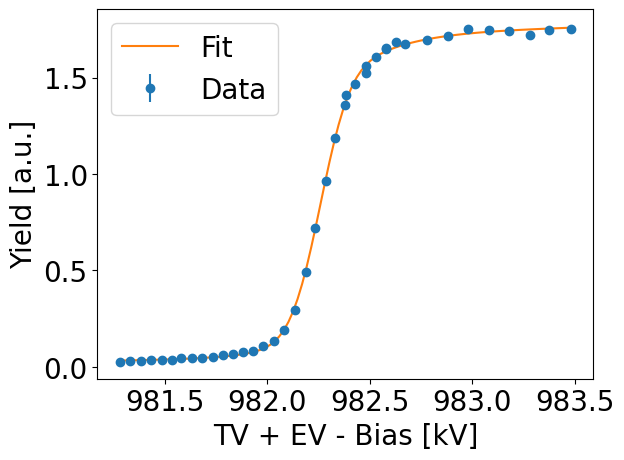

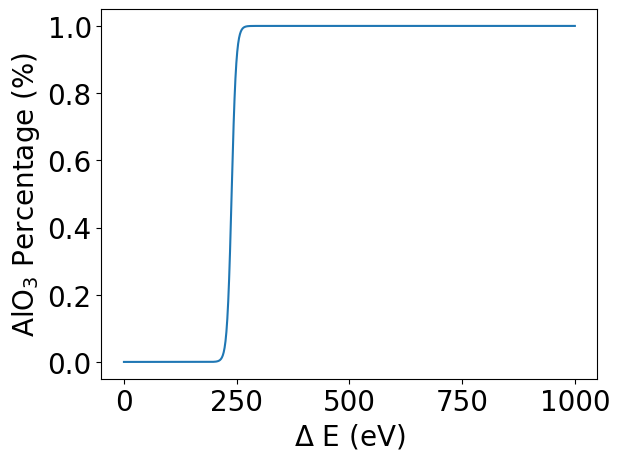

In [ ]:
# Increase font size
plt.rcParams.update({'font.size': 20})

mod = model( grid, theta )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o', label="Data" )
plt.plot( grid, mod, '-', label="Fit" )

plt.legend( )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

#plt.text( 625, 6, r'$\chi ^2 _r$: {:10.4f}'.format( out.redchi ) )

plt.savefig( "results/Fit_991_2024.pdf" )
plt.show( )

grid_oxide = np.linspace(0, 1, 1000)
oxide_step = smooth_step( grid_oxide, k=theta[5], x0=theta[4] )

plt.plot( grid_oxide * 1e3, oxide_step, label='Smooth step function' )
plt.ylabel( r'AlO$_{3}$ Percentage (%)' )
plt.xlabel( r'$\Delta$ E (eV)' )

plt.show( )

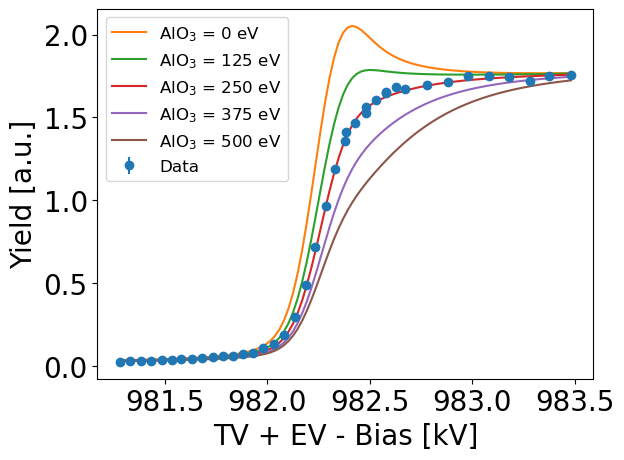

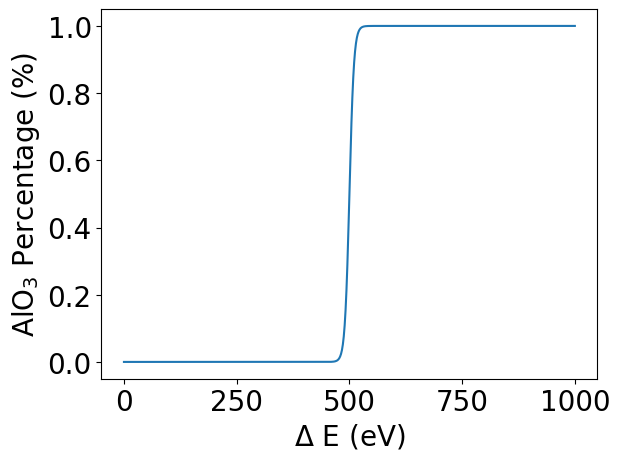

In [ ]:
# Increase font size
plt.rcParams.update({'font.size': 20})

steps = np.linspace(0, 0.5, 5)

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o', label="Data" )

theta[0] = 0.08

for step in steps:
    theta[4] = step
    mod = model( grid, theta )
    label = f'AlO$_{3}$ = ' + str( int(step*1e3) ) + ' eV' 
    plt.plot( grid, mod, '-', label=label )

plt.legend( fontsize=12, loc='upper left' )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

#plt.text( 625, 6, r'$\chi ^2 _r$: {:10.4f}'.format( out.redchi ) )

plt.savefig( "results/Fit_991_2024_Oxide.pdf" )
plt.show( )

grid_oxide = np.linspace(0, 1, 1000)
oxide_step = smooth_step( grid_oxide, k=theta[5], x0=theta[4] )

plt.plot( grid_oxide * 1e3, oxide_step, label='Smooth step function' )
plt.ylabel( r'AlO$_{3}$ Percentage (%)' )
plt.xlabel( r'$\Delta$ E (eV)' )

plt.show( )

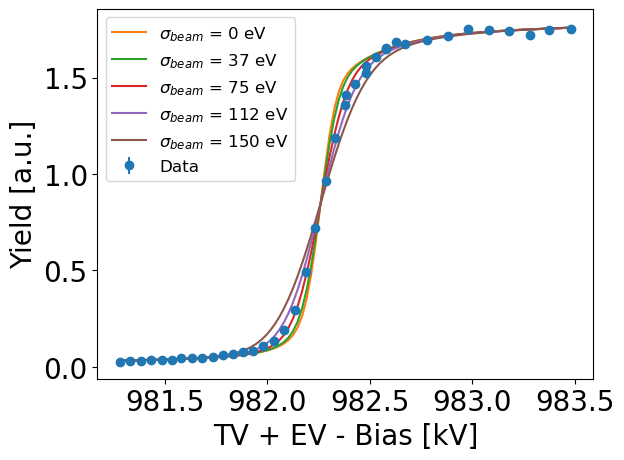

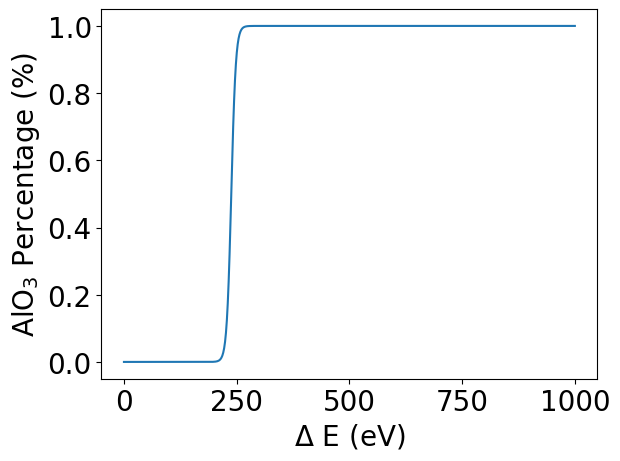

In [ ]:
# Increase font size
plt.rcParams.update({'font.size': 20})

steps = np.linspace(0, 0.15, 5)

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o', label="Data" )

theta[4] = 0.238
theta[5] = 200

for step in steps:
    theta[0] = step
    mod = model( grid, theta )
    label = r'$\sigma _{beam}$ = ' + str(int(step*1e3)) + ' eV'
    plt.plot( grid, mod, '-', label=label )

plt.legend( fontsize=12, loc='upper left' )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

#plt.text( 625, 6, r'$\chi ^2 _r$: {:10.4f}'.format( out.redchi ) )

plt.savefig( "results/Fit_991_2024_Sigma.pdf" )
plt.show( )

grid_oxide = np.linspace(0, 1, 1000)
oxide_step = smooth_step( grid_oxide, k=theta[5], x0=theta[4] )

plt.plot( grid_oxide * 1e3, oxide_step, label='Smooth step function' )
plt.ylabel( r'AlO$_{3}$ Percentage (%)' )
plt.xlabel( r'$\Delta$ E (eV)' )

plt.show( )

In [ ]:
# Print curve to txt file
with open( "results/Fit_991_2024.txt", "w" ) as f:
    for i in range( len( grid ) ):
        f.write( "{:10.4f} {:10.10f}\n".format( grid[i], mod[i] ) )

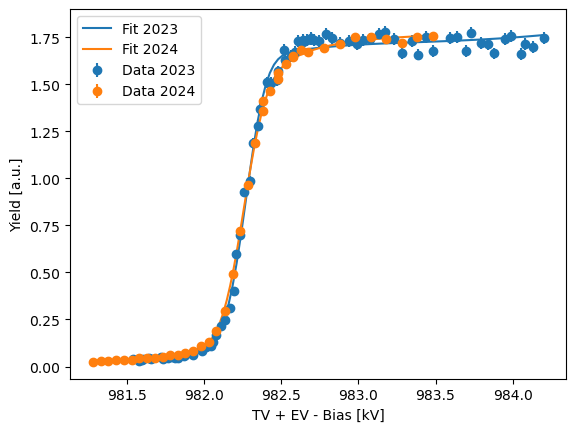

In [ ]:
# Load all the fits
mod_2023 = np.loadtxt( "results/Fit_991_2023.txt", skiprows=1 )
mod_2024 = np.loadtxt( "results/Fit_991_2024.txt", skiprows=1 )

# Load all the data
data_2023 = np.loadtxt( 'data/Data_991_2023.txt', skiprows=1 )
data_2024 = np.loadtxt( 'data/Data_991_2024.txt', skiprows=1 )

# Plot the data
plt.errorbar( data_2023[:, 0], data_2023[:, 1], yerr=data_2023[:, 2], fmt='o', label="Data 2023", color='tab:blue' )
plt.errorbar( data_2024[:, 0], data_2024[:, 1], yerr=data_2024[:, 2], fmt='o', label="Data 2024", color='tab:orange' )

plt.plot( mod_2023[:, 0], mod_2023[:, 1], '-', label="Fit 2023", color='tab:blue' )
plt.plot( mod_2024[:, 0], mod_2024[:, 1], '-', label="Fit 2024", color='tab:orange' )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

plt.legend( )
plt.savefig( "results/Fit_991.pdf" )